<a href="https://colab.research.google.com/github/Airee66/MAT421/blob/main/Digging_Into_Excess_Deaths_NotCleanedWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digging Into Excess Deaths:  An Analysis of U.S. Mortality and Improving Regression Models
### By Ainsley Chapman


## Introduction
The COVID-19 pandemic was an unprecedented worldwide event.  Three years later, the United States and the world are still feeling its effects.  One of the many impacts of the pandemic is the effect on excess deaths, which is particularly stark in the United States (Bilinski, Thompson, & Emmanuel, 2022).  At the highest peak in January 2021, excess deaths were up a remarkable 44.4% from the Centers for Disease Control and Prevention’s (CDC) average expected number of deaths (CDC, 2023).  A similar trend of considerably higher than expected number of deaths occurred in January 2022 and even with limited data for January 2023, deaths have again exceeded the predicted amount.  This highlights the need for a better model to more accurately fit and predict future mortality.



Dataset: https://data.cdc.gov/NCHS/Excess-Deaths-Associated-with-COVID-19/xkkf-xrst/

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcol
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import numpy as np
import numpy.polynomial.polynomial as poly
from scipy.interpolate import lagrange
import matplotlib.dates as mdates
import datetime as DT
import time
from sklearn.metrics import mean_squared_error, r2_score
import statistics
from statistics import mean

In [298]:
from google.colab import files
Dataset = files.upload()

Saving Excess_Deaths_Associated_with_COVID-19 Acessed April 22 copy.csv to Excess_Deaths_Associated_with_COVID-19 Acessed April 22 copy (1).csv


In [6]:
#ExDeaths = pd.read_csv('Excess_Deaths_Associated_with_COVID-19 fixed dates copy.csv', parse_dates=['Week_Ending_Date']) <-- Use this one
#ExDeaths = pd.read_csv('Excess_Deaths_Associated_with_COVID-19 fixed dates.csv', parse_dates=['Week Ending Date'])
ExDeaths = pd.read_csv('Excess_Deaths_Associated_with_COVID-19 Acessed April 22 copy.csv', parse_dates=['Week_Ending_Date'])
#df.sort_values(by='Week Ending Date', ascending=True)ExDeaths.head(3)
print('Causes of Death: \n', ExDeaths["Outcome"].unique())
ExDeaths.head(3)

Causes of Death: 
 ['All causes' 'All causes, excluding COVID-19' nan]


,Week_Ending_Date,State,Observed_Number,Upper_Bound_Threshold,Exceeds_Threshold,Average_Expected_Count,Excess_Estimate,Total_Excess_Estimate,Percent_Excess_Estimate,Year,Type,Outcome,Suppress,Note
0,2017-01-07,Alabama,1121.0,1136.0,False,1059.0,62.0,28913.0,5.852700,2017.0,Predicted (weighted),All causes,NaN,NaN
1,2017-01-07,Alaska,104.0,99.0,True,83.0,21.0,2688.0,25.372733,2017.0,Predicted (weighted),All causes,NaN,NaN
2,2017-01-07,Arizona,1170.0,1256.0,False,1164.0,6.0,41004.0,0.515397,2017.0,Predicted (weighted),All causes,NaN,NaN


Trimming data into smaller dataframes for analysis

In [299]:
ExDeaths.sort_values(by='Week_Ending_Date', ascending=True)
df1 = ExDeaths.loc[ExDeaths['State'] == 'United States']
df = ExDeaths.loc[ExDeaths['State'] == 'United States']
df.set_index(["Week_Ending_Date"], inplace=True)
#df.head(3)

Setting date index for data set:

In [300]:
ExDeaths.sort_values(by='Week_Ending_Date', ascending=True)
df = ExDeaths.loc[ExDeaths['State'] == 'United States']

df.set_index(["Week_Ending_Date"], inplace=True)

(array([45000., 50000., 55000., 60000., 65000., 70000., 75000., 80000.,
        85000., 90000.]),
 [Text(0, 45000.0, '45000'),
  Text(0, 50000.0, '50000'),
  Text(0, 55000.0, '55000'),
  Text(0, 60000.0, '60000'),
  Text(0, 65000.0, '65000'),
  Text(0, 70000.0, '70000'),
  Text(0, 75000.0, '75000'),
  Text(0, 80000.0, '80000'),
  Text(0, 85000.0, '85000'),
  Text(0, 90000.0, '90000')])

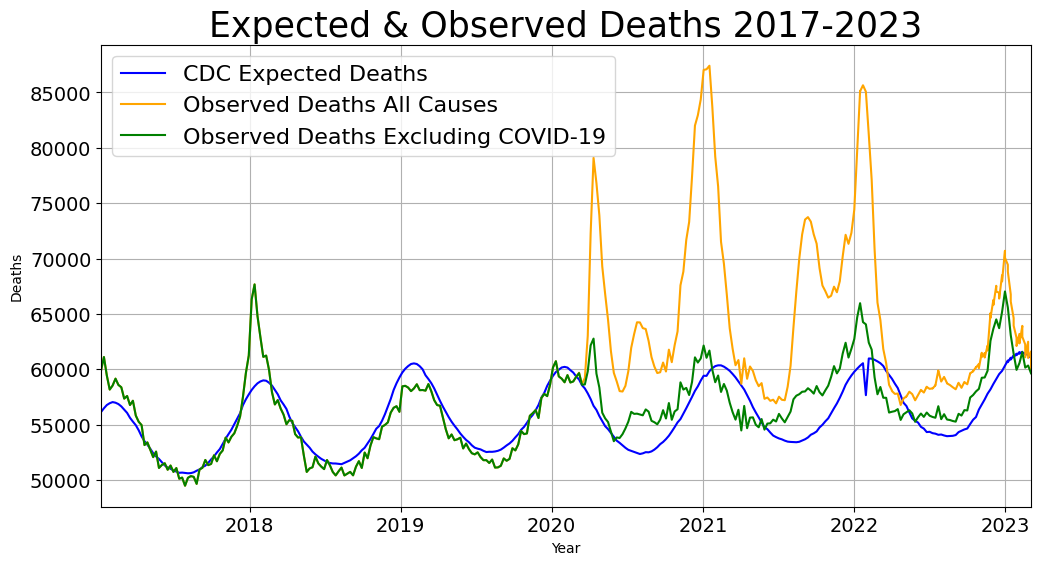

In [301]:
# put code for graph from proposal here

Alldf = df.loc[df['Outcome'] == 'All causes']
noc19df = df.loc[df['Outcome'] == 'All causes, excluding COVID-19']

fig, ax = plt.subplots(figsize=(12,6))
plt.title('Expected & Observed Deaths 2017-2023', fontsize = 25)
plt.xlabel('Year')
plt.ylabel('Deaths')
ax.plot(df['Average_Expected_Count'], '-b', label='CDC Expected Deaths')
ax.plot(Alldf['Observed_Number'], 'orange', label = "Observed Deaths All Causes")
ax.plot(noc19df['Observed_Number'], '-g', label = "Observed Deaths Excluding COVID-19")
ax.grid()
leg = ax.legend(fontsize = 16)
ax.set_xlim(pd.Timestamp('2017-01-07 00:00:00'), pd.Timestamp('2023-03-04 00:00:00'))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

## Background

The CDC estimate of expected deaths uses the prior six years of mortality data and excludes the most current 93 weeks of data.  Their model is then generated through approximate Bayesian inference by using integrated nested Laplace approximations (Rue, Martino, & Chopin, 2009).  This, of course, provides a clear visualization of the toll the pandemic has taken and a basis for approximated excess deaths due to the pandemic.  However, a realistic model for mortality is also needed.  


## Implementation

To design this model, I will construct different types of regression models from Dataset 1 (CDC, 2023) and determine the best fit model by calculating R2, mean square error (MSE), and root mean square error (RMSE) for each (Grace-Martin, 2020).  Some regression models and methods I plan to test are cubic spline, polynomial, and Gaussian.  Cubic spline interpolation utilizes piecewise cubic functions (splines) between points to generate an interpolating function (Bayen, Kong, and Siauw, 2020).  Poisson cubic spline regression was shown to be a robust and accurate predictor of mortality data (Shyamalkumar, 2005).  Polynomial regression will be used to fit the data as it is non-linear.  An appropriate order for the polynomial will be determined and the coefficients will be calculated using least squares (Bayen, Kong, and Siauw, 2020).  The method that the CDC uses is a type of Gaussian regression (Rue, Martino, & Chopin, 2009) which makes it a good candidate and an appropriate type of method to use.  Gaussian Process Regression (PCR) reconstructs the underlying signal of some given data by eigendecomposition to reduce noise and can be used to predict future values through machine learning (Rasmussen & Williams, 2006)   <br> <br>


### Data Cleaning

In [10]:
#I dont think we need this cell but keeping here just in case

#Datesdf = Alldf[["Week Ending Date"]]

#df1 = ExDeaths.loc[ExDeaths['State'] == 'United States']
Alldf1 = df1.loc[df1['Outcome'] == 'All causes']

#print(len(Alldf))
#Alldf.head(3)

Remove weighted duplicate data and keep unweighted points

In [11]:
Alldf_new = Alldf.loc[Alldf['Type'] == 'Unweighted']
print(len(Alldf_new))
Alldf_new.head(3)

322


,State,Observed_Number,Upper_Bound_Threshold,Exceeds_Threshold,Average_Expected_Count,Excess_Estimate,Total_Excess_Estimate,Percent_Excess_Estimate,Year,Type,Outcome,Suppress,Note
Week_Ending_Date,,,,,,,,,,,,,
2017-01-07,United States,59901.0,58450.0,True,56151.0,3750.0,1335710.0,6.678393,2017.0,Unweighted,All causes,NaN,NaN
2017-01-14,United States,61118.0,58604.0,True,56489.0,4629.0,1335710.0,8.194464,2017.0,Unweighted,All causes,NaN,NaN
2017-01-21,United States,59445.0,58767.0,True,56781.0,2664.0,1335710.0,4.691676,2017.0,Unweighted,All causes,NaN,NaN


In [12]:
#Not needed, for ref only
#x = list(range(0,319))
#print(len(x))

In [13]:
#Prob not needed anymore
All2 = Alldf_new.index.to_julian_date()
print(All2)

Float64Index([2457760.5, 2457767.5, 2457774.5, 2457781.5, 2457788.5, 2457795.5,
              2457802.5, 2457809.5, 2457816.5, 2457823.5,
              ...
              2459944.5, 2459951.5, 2459958.5, 2459965.5, 2459972.5, 2459979.5,
              2459986.5, 2459993.5, 2460000.5, 2460007.5],
             dtype='float64', name='Week_Ending_Date', length=322)


###  Cubic Spline

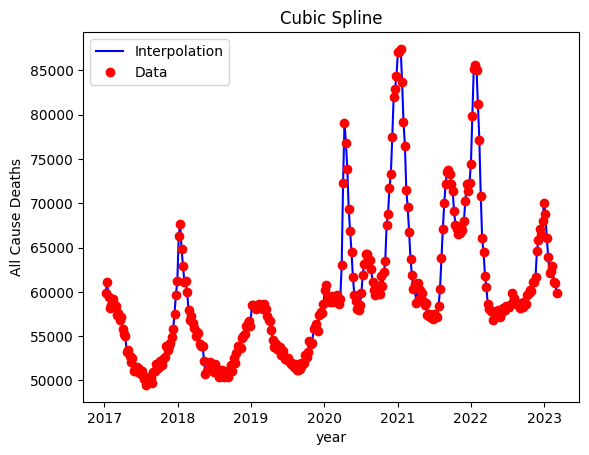

In [14]:
# Dates are working!!!
from sklearn.metrics import mean_squared_error, r2_score

x = Alldf_new.index
y = Alldf_new['Observed_Number']
f = CubicSpline(x, y)

start = pd.Timestamp('2017-01-07')
end = pd.Timestamp('2023-03-04')
xn = np.linspace(start.value, end.value, 322)
xn = pd.to_datetime(xn)
yn = f(xn)

plt.plot(xn, yn, 'b', label = 'Interpolation')
plt.plot(x, y, 'ro', label = 'Data')
plt.title('Cubic Spline')
plt.legend()
plt.xlabel('year')
plt.ylabel('All Cause Deaths')
plt.show()



In [ ]:
#print(yn)

To calculate mse and r2 we need to have the exact same number of points and thus come out equal.  

In [ ]:
mse = mean_squared_error(y, yn)
print(mse)
r2 = r2_score(y, yn)
print(r2)

0.0
1.0


In [18]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

model_6 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)


plt.plot(x, y, ls='', marker='.', label='originals')
plt.plot(x, y_est_6, marker='.', label='n_knots = 6')
plt.plot(x, y_est_15, marker='.', label='n_knots = 15')
plt.legend(); plt.show()

NameError: ignored

https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines

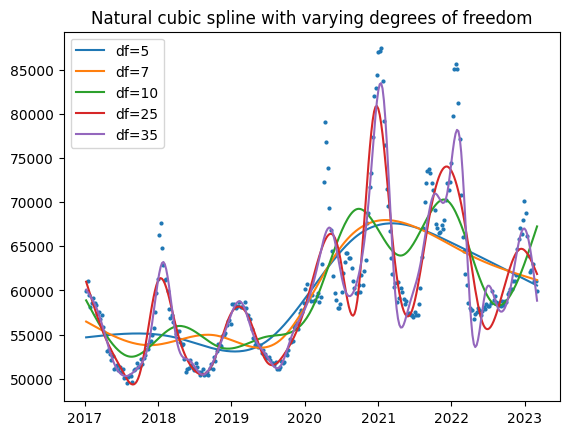

35


In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
from patsy import cr
import matplotlib.pyplot as plt

n_obs = 322
np.random.seed(0)
x = mdates.date2num(Alldf_new.index)
y = y


def plot_smoothed(df=5):

    # Generate spline basis with different degrees of freedom
    x_basis = cr(x, df=df, constraints="center")

    # Fit model to the data
    model = LinearRegression().fit(x_basis, y)

    # Get estimates
    y_hat = model.predict(x_basis)

    plt.plot(x, y_hat, label=f"df={df}")


plt.scatter(Alldf_new.index, y, s=4, color="tab:blue")

for df in (5, 7, 10, 25, 35):
    plot_smoothed(df)

plt.legend()
plt.title(f"Natural cubic spline with varying degrees of freedom")
plt.show()

print(df)

MSE for df 45 : 1664242.336096412
RMSE for df 45 : 1290.0551678499692
Normalized RMSE:  0.02158655170584772
R2 for df 45 : 0.9733439542019233


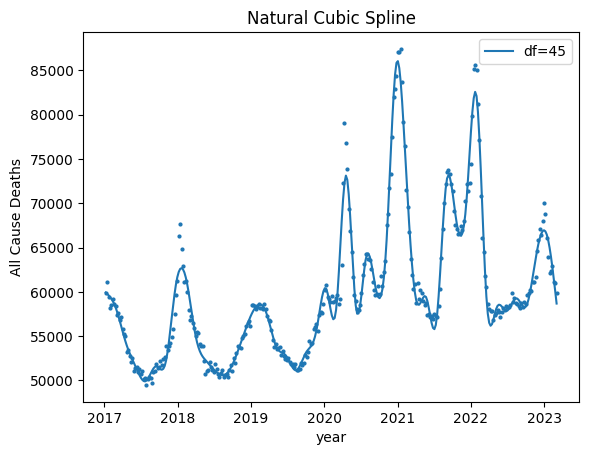

In [295]:
import math
def cube_smooth(df=5):

    # Generate spline basis with different degrees of freedom
    x_basis = cr(x, df=df, constraints="center")

    # Fit model to the data
    model = LinearRegression().fit(x_basis, y)
    #print(model)

    # Get estimates
    y_hat = model.predict(x_basis)
    #return y_hat
    #print(y_hat)

    mse = mean_squared_error(y, y_hat)
    print("MSE for df", df, ":", mse)
    RMSE = math.sqrt(mse)
    print("RMSE for df", df, ":", RMSE)
    NormRMSE = RMSE/mean(y)
    print("Normalized RMSE: ", NormRMSE)
    r2 = r2_score(y, y_hat)
    print("R2 for df", df, ":", r2)

    plt.plot(x, y_hat, label=f"df={df}")
    plt.xlabel('year')
    plt.ylabel('All Cause Deaths')

x = mdates.date2num(Alldf_new.index)
y = y

plt.scatter(Alldf_new.index, y, s=4, color="tab:blue")
cube_smooth(45)

plt.legend()
plt.title(f"Natural Cubic Spline")
plt.show()


MSE for df 3 : 35482643.78343948
RMSE for df 3 : 5956.730964500535
Normalized RMSE:  0.09967424972787611
R2 for df 3 : 0.4316771318612749
MSE for df 10 : 29132793.16125174
RMSE for df 10 : 5397.480260385557
Normalized RMSE:  0.09031628229999498
R2 for df 10 : 0.5333822173075431
MSE for df 20 : 10481572.574327998
RMSE for df 20 : 3237.5256870529997
Normalized RMSE:  0.054173664339529595
R2 for df 20 : 0.8321174311473795
MSE for df 30 : 8191894.346459509
RMSE for df 30 : 2862.1485542262667
Normalized RMSE:  0.04789246172982886
R2 for df 30 : 0.8687910371368054
MSE for df 45 : 1664242.336096412
RMSE for df 45 : 1290.0551678499692
Normalized RMSE:  0.02158655170584772
R2 for df 45 : 0.9733439542019233


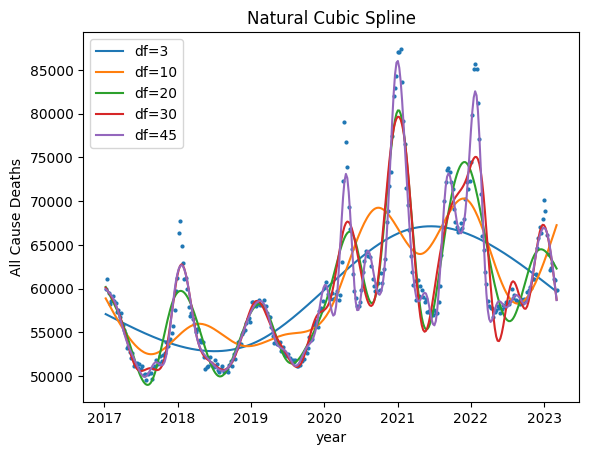

In [296]:
plt.scatter(Alldf_new.index, y, s=4, color="tab:blue")

for df in (3, 10, 20, 30, 45):
    cube_smooth(df)

plt.legend(loc = "upper left")
plt.title(f"Natural Cubic Spline")
plt.show()

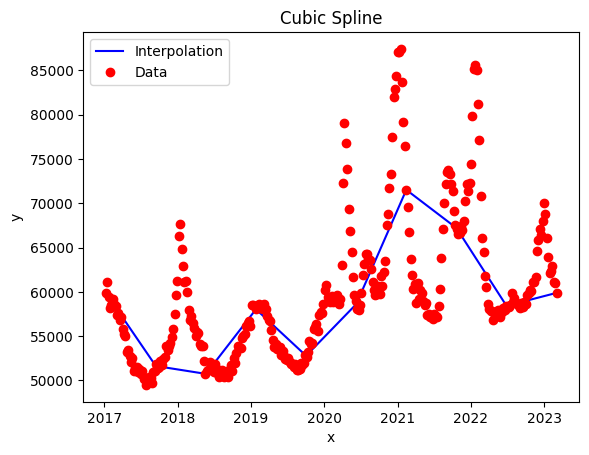

[59901.         51633.35758869 50741.4761953  58037.
 52785.54585735 58607.28554855 71513.         67207.30283897
 58419.11192817 59885.        ]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

x = Alldf_new.index
y = Alldf_new['Observed_Number']
f = CubicSpline(x, y)

start = pd.Timestamp('2017-01-07')
end = pd.Timestamp('2023-03-04')
xn = np.linspace(start.value, end.value, 10)
xdate = pd.to_datetime(xn)
yn = f(xdate)

#print(xn)

plt.plot(xdate, yn, 'b', label = 'Interpolation')
plt.plot(x, y, 'ro', label = 'Data')
plt.title('Cubic Spline')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(yn)

### Polynomial Regression

Best fit for now vv

/usr/local/lib/python3.9/dist-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


MSE:  30900516.248589177
RMSE:  5558.823279129242
Normalized RMSE:  0.09301604235932073
R2:  0.5050687280083173


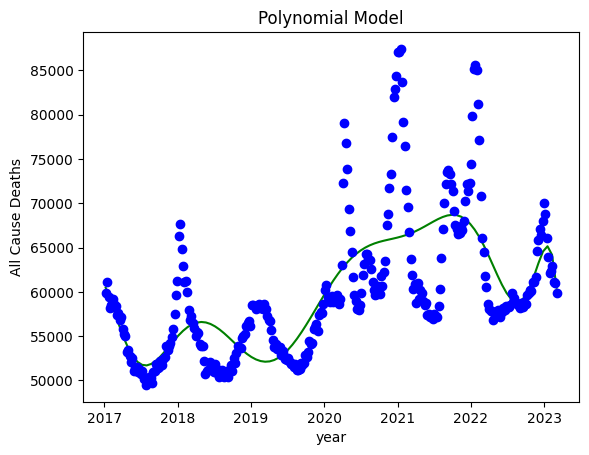

In [294]:
import matplotlib.dates as mdates
import datetime as DT
import time
from sklearn.metrics import mean_squared_error, r2_score
import statistics
from statistics import mean

x = Alldf_new.index
y = Alldf_new['Observed_Number']

xp = mdates.date2num(Alldf_new.index)
#print(x)

z4 = np.polyfit(xp, y, 36)  # this is our function
p4 = np.poly1d(z4)
yfit = np.polyval(z4,xp)

fig, cx = plt.subplots()
plt.xlabel('year')
plt.ylabel('All Cause Deaths')
plt.title("Polynomial Model")

xx = np.linspace(xp.min(), xp.max(), 100)
dd = mdates.num2date(xx)

cx.plot(dd, p4(xx), '-g', label = 'Polynomial')
cx.plot(x, y, 'bo', label = 'Data')

#coefs = np.polyfit(x, y, 10)
#poly = np.poly1d(coefs)
#print(p4)

mse = mean_squared_error(y, yfit)
print("MSE: ", mse)
RMSE = math.sqrt(mse)
print("RMSE: ", RMSE)
NormRMSE = RMSE/mean(y)
print("Normalized RMSE: ", NormRMSE)
r2 = r2_score(y, yfit)
print("R2: ", r2)


In [ ]:
print(yfit)

[60460.875     60102.59375   59706.9765625 59282.15625   58835.546875
 58373.875     57903.2265625 57429.140625  56956.5859375 56490.015625
 56033.3046875 55589.953125  55162.9453125 54754.90625   54368.015625
 54004.15625   53664.828125  53351.2578125 53064.296875  52804.6328125
 52572.6484375 52368.4609375 52192.1015625 52043.28125   51921.5859375
 51826.4453125 51757.1640625 51712.8828125 51692.7109375 51695.53125
 51720.234375  51765.65625   51830.515625  51913.5       52013.2109375
 52128.3046875 52257.40625   52399.09375   52551.8828125 52714.4609375
 52885.3515625 53063.1953125 53246.640625  53434.3125    53624.96875
 53817.3125    54010.1171875 54202.234375  54392.546875  54579.9453125
 54763.4296875 54942.03125   55114.84375   55281.046875  55439.8828125
 55590.5625    55732.4921875 55865.0546875 55987.71875   56100.0625
 56201.625     56292.109375  56371.2265625 56438.7734375 56494.578125
 56538.5859375 56570.6875    56590.9453125 56599.4453125 56596.296875
 56581.6328125 565

MSE and r2 calculated here:

/usr/local/lib/python3.9/dist-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


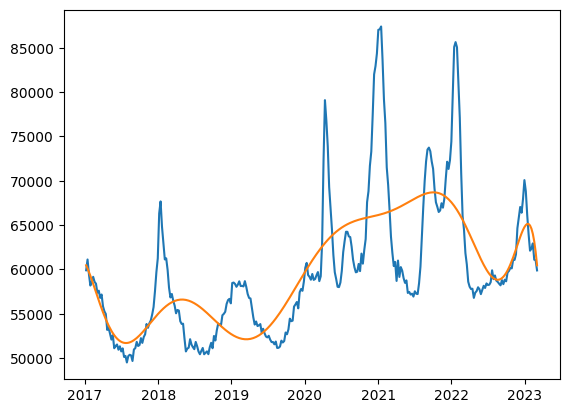

30900516.248589177
0.5050687280083173


In [ ]:
x = Alldf_new.index
y = Alldf_new['Observed_Number']

xd = mdates.date2num(Alldf_new.index)

p = np.polyfit(xd,y,36) # insufficient degree to include sqrt

yfit = np.polyval(p,xd)


plt.plot(x,y, label='data')
plt.plot(x,yfit, label='fit')
#plt.plot(x,yfit-y, label='var')
plt.show()

# model evaluation
mse = mean_squared_error(y, yfit)
print(mse)
r2 = r2_score(y, yfit)
print(r2)

### Gaussian Regression

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
#gaussian_process.fit(X_train, y_train)
#gaussian_process.kernel_

x = Alldf_new.index
y = Alldf_new['Observed_Number']

xd = mdates.date2num(Alldf_new.index)
rx = xd.reshape(-1, 1)
#ry = y.reshape(-1, 1)

mean_prediction, std_prediction = gaussian_process.predict(y, return_std=True)

plt.plot(x, y, label=r"data", linestyle="dotted")
#plt.scatter(X_train, y_train, label="Observations")
plt.plot(rx, mean_prediction, label="Mean prediction")
plt.fill_between(
    xd.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

AttributeError: ignored

In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic

X = (Alldf_new.index.year + Alldf_new.index.month / 12).to_numpy().reshape(-1, 1)
#X = mdates.date2num(Alldf_new.index)
#X = X.reshape(-1, 1)
y = Alldf_new['Observed_Number'].to_numpy()

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

c19_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
c19_kernel

In [ ]:
y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=c19_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

In [ ]:
import datetime
import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start = 2017, stop = current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

plt.plot(X, y, color="black", linestyle="dashed", label="Deaths")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

In [ ]:
import numpy as np
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# setup data
x = Alldf_new.index
x = mdates.date2num(Alldf_new.index)
y = Alldf_new['Observed_Number']

#xi = np.linspace(0, 10, 101)
xi = np.linspace(xp.min(), xp.max(), 100)

# use fitpack2 method
ius = InterpolatedUnivariateSpline(x, y)
yi = ius(xi)

#plt.subplot(2, 1, 1)
plt.plot(x, y, 'bo')
plt.plot(xi, yi, 'g')
plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using univariate spline')
plt.show()

# use RBF method
rbf = Rbf(x, y)
fi = rbf(xi)

plt.subplot(2, 1, 2)
plt.plot(x, y, 'bo')
plt.plot(xi, yi, 'g')
plt.plot(xi, np.sin(xi), 'r')
plt.title('Interpolation using RBF - multiquadrics')

#plt.savefig('rbf1d.png')

### Curve fit Scipy

In [ ]:
from scipy import optimize

x = Alldf_new.index
y = Alldf_new['Observed_Number']

xd = mdates.date2num(Alldf_new.index)

# let's define the function form
def func(x, a, b):
    y = a*np.exp(b*x)
    return y

alpha, beta = optimize.curve_fit(func, xdata = xd, ydata = y)[0]
print(f'alpha={alpha}, beta={beta}')

# Let's have a look of the data
plt.figure(figsize = (10,8))
plt.plot(x, y, 'b.')
plt.plot(xd, alpha*np.exp(beta*xd), 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Extra Material

Trying this: https://www.geeksforgeeks.org/polynomial-regression-for-non-linear-data-ml/?ref=rp


In [ ]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
  
# Importing the dataset
## x = data, y = quadratic equation
x = All2
x1 = x.values.reshape(-1, 1)
y = Alldf_new['Observed_Number']

# data points
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non Linear Data')



In [ ]:
# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x1, y)
print('Slope of the line is', regression_model.coef_)
print('Intercept value is', regression_model.intercept_)
# Predict
y_predicted = regression_model.predict(x1)

In [ ]:
# data points
plt.scatter(x, y, s = 10)
plt.xlabel("$x$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.title("data points")
  
# predicted values
plt.plot(x, y_predicted, color ='g')

In [ ]:
# model evaluation
mse = mean_squared_error(y, y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
  
# printing values
  
print('MSE of Linear model', mse)
  
print('R2 score of Linear model: ', r2)

In [ ]:
poly_features = PolynomialFeatures(degree = 20, include_bias = False)
x_poly = poly_features.fit_transform(x1)
#x[4]


In [ ]:

x_poly[3]

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
print('Coefficients of x are', lin_reg.coef_)
print('Intercept is', lin_reg.intercept_)

In [ ]:
x_new = np.linspace(2457760.5, 2459986.5, 100).reshape(100, 1)
x_new_poly = poly_features.transform(x_new)
y_new = lin_reg.predict(x_new_poly)
plt.plot(x, y, "b.")
plt.xlim(2457760.5, 2459986.5)
plt.plot(x_new, y_new, "r-", linewidth = 2, label ="Predictions")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize = 18)
plt.legend(loc ="upper left", fontsize = 14)
  
plt.title("Quadratic_predictions_plot")
plt.show()

### Gaussian Regression

Curve fitting with scipy: https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html

[285.33022527   2.00244291]


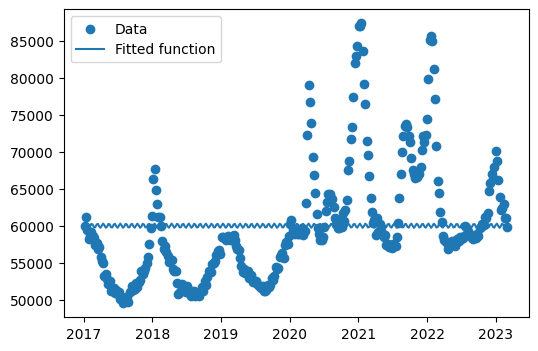

In [ ]:
from scipy import optimize

x = Alldf_new.index
xn = mdates.date2num(Alldf_new.index)
y = Alldf_new['Observed_Number']

def test_func(x, a, b):
    return a * np.sin(b * xn) + 60000

params, params_covariance = optimize.curve_fit(test_func, xn, y,
                                               p0=[2, 2])

print(params)

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data')
plt.plot(xn, test_func(xn, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')
plt.show()

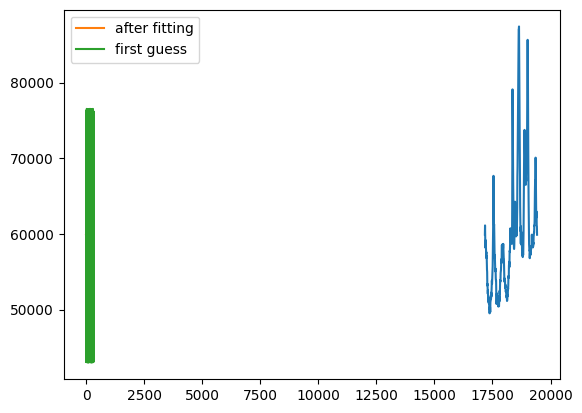

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import pylab as plt
x = mdates.date2num(Alldf_new.index)
y = Alldf_new['Observed_Number']

N = 319 # number of data points
t = x
data = Alldf_new['Observed_Number'] # create artificial data with noise

guess_freq = 1
guess_amplitude = 3*np.std(data)/(2**0.5)
guess_phase = 0
guess_offset = np.mean(data)

p0=[guess_freq, guess_amplitude,
    guess_phase, guess_offset]

# create the function we want to fit
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# now do the fit
fit = curve_fit(my_sin, t, data, p0=p0)

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = my_sin(t, *p0)

# recreate the fitted curve using the optimized parameters
data_fit = my_sin(t, *fit[0])

plt.plot(x,y)
plt.plot(data_fit, label='after fitting')
plt.plot(data_first_guess, label='first guess')
plt.legend()
plt.show()

#### Lagrange poly

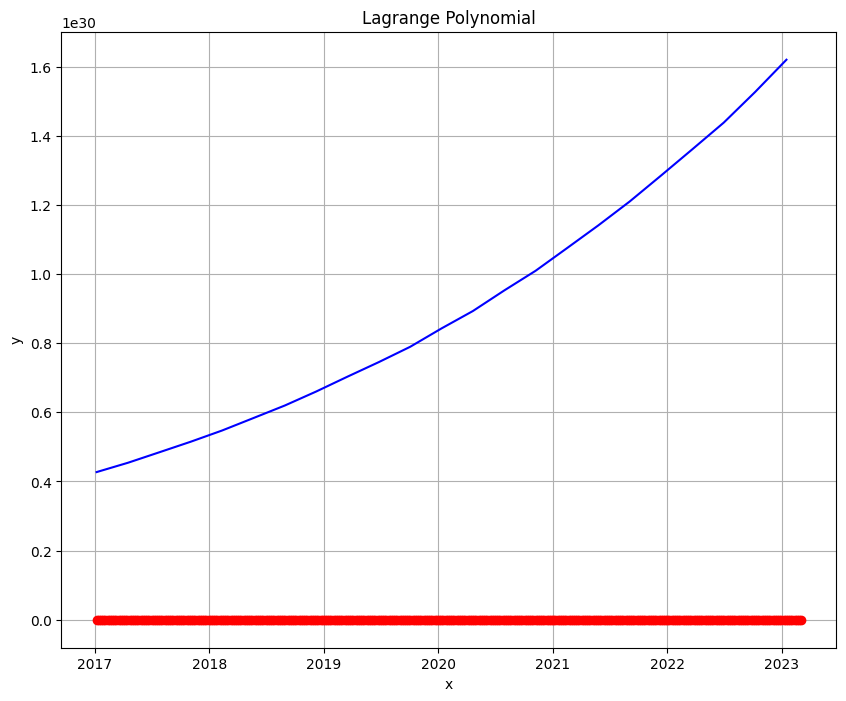

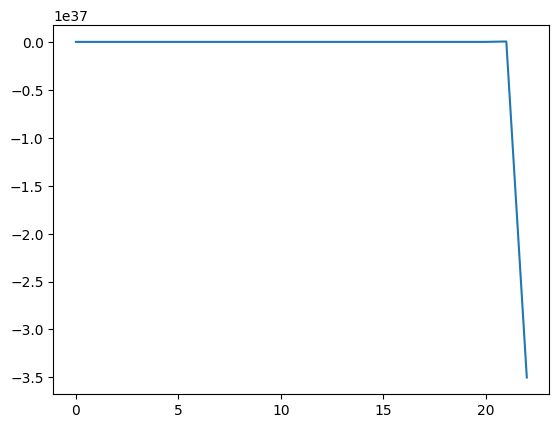

In [220]:
from scipy.interpolate import lagrange

xd = mdates.date2num(Alldf_new.index)
x = Alldf_new.index
y = Alldf_new['Observed_Number']

x_new = np.arange(min(xd), max(xd), 100)

f = lagrange(x_new, y)
fig = plt.figure(figsize = (10,8))
plt.plot(x_new, f(x_new), 'b', x, y, 'ro')
plt.title('Lagrange Polynomial')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(f)

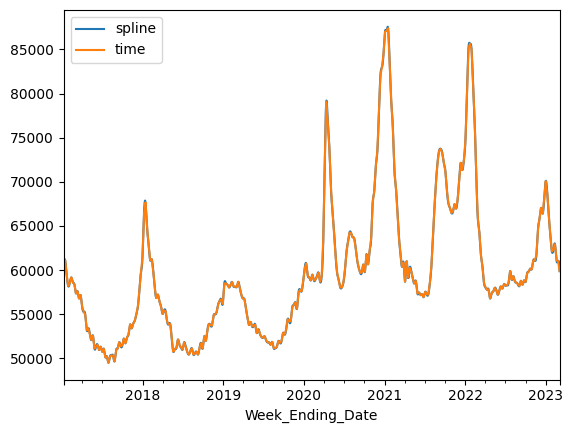

In [ ]:
ts = pd.Series(y, index=Alldf_new.index)
ts[ts==-1] = np.nan
ts = ts.resample('T').mean()

ts.interpolate(method='spline', order=3).plot()
ts.interpolate(method='time').plot()
plt.plot(Alldf['Observed_Number'], 'orange', label = "Observed Deaths All Causes")
lines, labels = plt.gca().get_legend_handles_labels()
labels = ['spline', 'time']
plt.legend(lines, labels, loc='best')
plt.show()

In [34]:
ts = pd.Series(y, index=Alldf_new.index)
ts[ts==-1] = np.nan
ts = ts.resample('T').mean()

a = ts.interpolate(method='spline', order=3)
b = ts.interpolate(method='time')
c = ts.interpolate(method = 'gaussian')

fig, ax = plt.subplots(figsize=(12,6))
plt.title('Expected & Observed Deaths 2017-2023', fontsize = 30)

ax.plot(Alldf_new['Observed_Number'], 'orange', label = "Observed Deaths All Causes")
ax.plot(a, label = 'a')
ax.plot(b, label = 'b')
ax.grid()
leg = ax.legend(fontsize = 16)
ax.set_xlim(pd.Timestamp('2017-01-07 00:00:00'), pd.Timestamp('2023-03-04 00:00:00'))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

ValueError: ignored

In [ ]:
# extract month and year from dates
Regdf = Alldf_new
Regdf['Month'] = Regdf.index.month
Regdf['Year'] = Regdf.index.year
# create a sequence of numbers
Regdf['Series'] = np.arange(1,len(Regdf)+1)
# drop unnecessary columns and re-arrange
#Regdf.drop(Regdf.index, axis=1, inplace=True)
data = Regdf[[ 'Year', 'Month', 'Observed_Number']] 
# check the head of the dataset
data.head()


<ipython-input-38-886c88547680>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Regdf['Month'] = Regdf.index.month
<ipython-input-38-886c88547680>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Regdf['Year'] = Regdf.index.year
<ipython-input-38-886c88547680>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,Year,Month,Observed_Number
Week_Ending_Date,,,
2017-01-07,2017,1,59901.0
2017-01-14,2017,1,61118.0
2017-01-21,2017,1,59445.0
2017-01-28,2017,1,58178.0
2017-02-04,2017,2,58541.0


In [ ]:
# split data into train-test set
train = data[data['Year'] < 2023]
test = data[data['Year'] >= 2023]

# import the regression module
import pycaret as pc
from pycaret.regression import *
# initialize setup
s = setup(data = train, test_data = test, target = 'Passengers', fold_strategy = 'timeseries', numeric_features = ['Year', 'Series'], fold = 3, transform_target = True, session_id = 123)

In [38]:
x = Alldf_new.index
y = Alldf_new['Observed_Number']

xp = mdates.date2num(Alldf_new.index)
xx = np.linspace(xp.min(), xp.max(), 100)
dd = mdates.num2date(xx)

xs = x
x_fine = dd
ys, y_fine = fn(xs), fn(x_fine)



from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k

kernels = [
    k.RBF(length_scale=1.0, length_scale_bounds=(1.0, 1.01)), 
    k.RBF(length_scale=2.0, length_scale_bounds=(2.0, 2.01)),
    k.RBF(length_scale=20.0, length_scale_bounds=(20.0, 20.01)),
]

# Make some axes please
fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for kernel, ax in zip(kernels, axes):
    # Fit the GP, which doesnt do much as we fixed the length_scale
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    # The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
    y_mean, y_std = gp.predict(x[:, None], return_std=True)

    ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
    ax.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
    ax.set_title(f"{kernel}\n{y_std.max():0.4f}")

TypeError: ignored

In [58]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 5**2 * RBF(length_scale=5)

from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [59]:
c19_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
c19_kernel

5**2 * RBF(length_scale=5) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [61]:
from sklearn.gaussian_process import GaussianProcessRegressor

x = Alldf_new.index
X = (Alldf_new.index.year + Alldf_new.index.month / 12).to_numpy().reshape(-1, 1)
y = Alldf_new['Observed_Number']
#print(X)

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=c19_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gau

GaussianProcessRegressor(kernel=5**2 * RBF(length_scale=5) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [62]:
import datetime
import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
print(current_month)
X_test = np.linspace(start=2017, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

2023.3333333333333


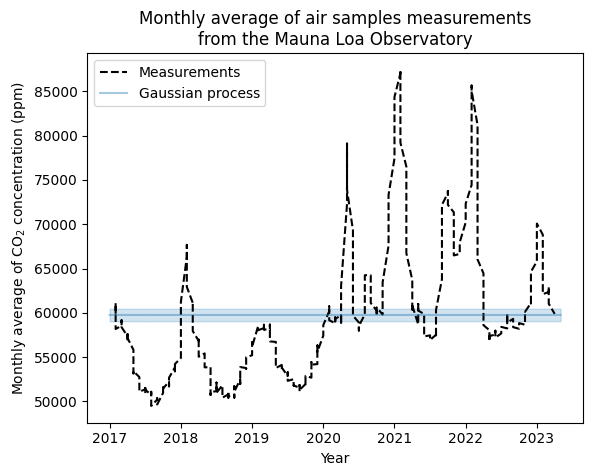

In [63]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

In [64]:
gaussian_process.kernel_

316**2 * RBF(length_scale=1e-05) + 316**2 * RBF(length_scale=1e-05) * ExpSineSquared(length_scale=1e-05, periodicity=1) + 316**2 * RationalQuadratic(alpha=1.34, length_scale=1e-05) + 316**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=1e+05)

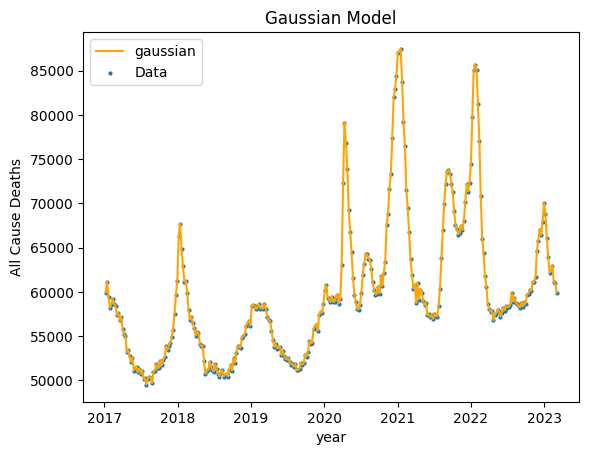

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


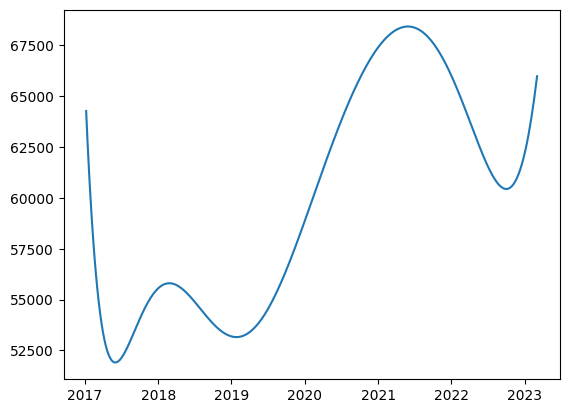

In [292]:
from pandas.core.groupby.groupby import sample
from scipy import interpolate
from scipy import optimize

x = Alldf_new.index
y = Alldf_new['Observed_Number']

xp = mdates.date2num(Alldf_new.index)
xx = np.linspace(xp.min(), xp.max(), 322)
#yy = np.linspace(y.min(), y.max(), 40)
dd = mdates.num2date(xx)
#print(dd)

for kind in ['gaussian']:
  newfunc = interpolate.Rbf(xp, y, function = kind, smooth = 0.001) 
  fnew = newfunc(xx)
  plt.plot(dd, fnew, color = "orange", label = kind)

#plt.plot(x, y, 'bo', s=4,  label = "Data")
plt.scatter(Alldf_new.index, y, s=4, color="tab:blue", label = "Data")
plt.legend(loc = 'upper left')
plt.xlabel('year')
plt.ylabel('All Cause Deaths')
plt.title("Gaussian Model")
plt.show()


a = np.polyfit(xx, fnew, 20)
yfit = np.polyval(a, xp)
plt.plot(x, yfit)
plt.show()



In [293]:
mse = mean_squared_error(y, fnew)
print("MSE: ", mse)
RMSE = math.sqrt(mse)
print("RMSE: ", RMSE)
NormRMSE = RMSE/mean(y)
print("Normalized RMSE: ", NormRMSE)
r2 = r2_score(y, fnew)
print("R2: ", r2)

MSE:  1171.9796252533774
RMSE:  34.234187959602274
Normalized RMSE:  0.0005728422217239689
R2:  0.9999812284894528


[234.5186181   1.9970121]


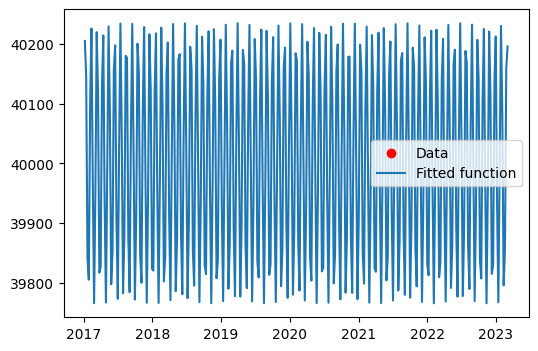

In [290]:
def test_func(x, a, b):
    return a * np.sin(b * x) + 40000

params, params_covariance = optimize.curve_fit(test_func, xp, yfit,
                                               p0=[2, 2])

print(params)
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data', color = "red")
plt.plot(dd, test_func(xx, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()
#newfunc.function
#curve_fit(newfunc, xp, y)
#yfit = fnew.predict(newfunc)

#plt.plot(dd, y)

In [282]:
x = Alldf_new.index
y = Alldf_new['Observed_Number']

xp = mdates.date2num(Alldf_new.index)
xx = np.linspace(xp.min(), xp.max(), 40)
x2 = np.linspace(xp.min(), xp.max(), 322)
#yy = np.linspace(y.min(), y.max(), 40)
dd = mdates.num2date(xx)
#print(dd)

for kind in ['gaussian']:
  newfunc = interpolate.Rbf(xp, y, function = kind, smooth = 0.001) 
  #a = sample(newfunc, 322)
  fnew = newfunc(xx)
  plt.plot(dd, fnew, color = "orange", label = kind)

#plt.plot(x, y, 'bo', s=4,  label = "Data")
plt.scatter(Alldf_new.index, y, s=4, color="tab:blue", label = "Data")
plt.legend(loc = 'upper left')
plt.show()

TypeError: ignored

In [281]:
mse = mean_squared_error(y, fnew)
print("MSE: ", mse)
r2 = r2_score(y, fnew)
print("R2: ", r2)
RMSE = math.sqrt(mse)
print("RMSE: ", RMSE)
#print(fnew)

ValueError: ignored

In [170]:
# Define the Gaussian function
def Gauss(x, A, B):
    #y = A*np.exp(-1*B*x**2)
    y = A * np.sin(B * x)
    return y

In [185]:
Gdf = Alldf_new.resample(pd.DateOffset)

ValueError: ignored

[1.11854430e+03 9.83450305e-01]


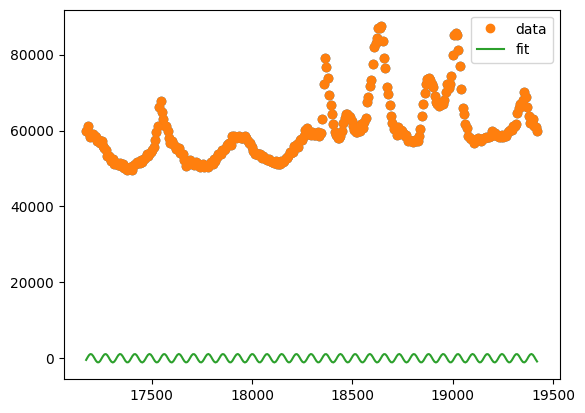

In [133]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#xdata = x
ydata = Alldf_new['Observed_Number']

xp = mdates.date2num(Alldf_new.index)
xx = np.linspace(xp.min(), xp.max(), 322)
dd = mdates.num2date(xx)

# Recast xdata and ydata into numpy arrays so we can use their handy features
#xdata = np.asarray(xdata)
xdata = xx
ydata = np.asarray(ydata)
plt.plot(xdata, ydata, 'o')
  
# Define the Gaussian function
def Gauss(x, A, B):
    #y = A*np.exp(-1*B*x**2)
    y = A * np.sin(B * x)
    return y
parameters, covariance = curve_fit(Gauss, xdata, ydata)
  
fit_A = parameters[0]
fit_B = parameters[1]
print(parameters)
  
fit_y = Gauss(xdata, fit_A, fit_B)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

#print(fit_y)

Sine function coefficients:
[-3.07603427e+04 -4.54715483e-01]
Covariance of coefficients:
[[1.96143224e+07 2.13118158e+01]
 [2.13118158e+01 6.63803595e-04]]


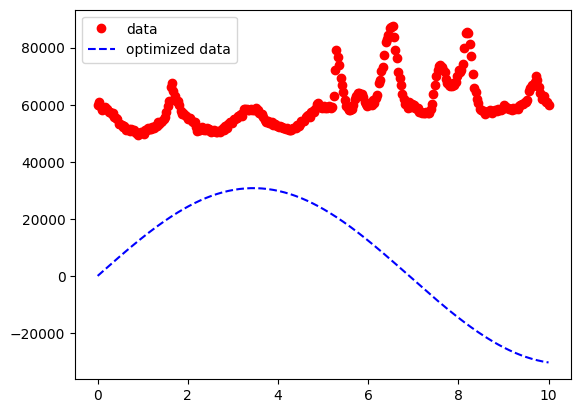

In [154]:
#x = Alldf_new.index
x = np.linspace(0, 10, 322)
#x = mdates.date2num(Alldf_new.index)
#x = np.linspace(xp.min(), xp.max(), 322)
#x = np.linspace(0, 10, num = 40)
 
# The coefficients are much bigger.
y = Alldf_new['Observed_Number']
 
def test(x, a, b):
    return a * np.cos(b * x) + 60
 
param, param_cov = curve_fit(test, x, y)
 
print("Sine function coefficients:")
print(param)
print("Covariance of coefficients:")
print(param_cov)
 
ans = (param[0]*(np.sin(param[1]*x)))
 
plt.plot(x, y, 'o', color ='red', label ="data")
plt.plot(x, ans, '--', color ='blue', label ="optimized data")
plt.legend()
plt.show()

## Conclusion

## References

Bilinski A, Thompson K, and Emanuel E. COVID-19 and Excess All-Cause Mortality in the US and 20 Comparison Countries, June 2021-March 2022. JAMA. 2023;329(1):92–94. doi:10.1001/jama.2022.21795
CDC. (2023, February 22). Excess deaths associated with covid-19. Centers for Disease Control and Prevention. Retrieved February 24, 2023, from https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm#references <br><br>
Grace-Martin, K. (2020). Assessing the fit of regression models - CSCU. Retrieved February 26, 2023, from https://cscu.cornell.edu/wp-content/uploads/68_regfit.pdf 
<br><br>
Kong, Q., Siauw, T. and Bayen, A. (2020). Python programming and numerical methods: A guide for engineers and Scientists. Retrieved February 25, 2023, from https://pythonnumericalmethods.berkeley.edu/notebooks/Index.html 
<br><br>
Rasmussen, C. E. and Williams, C. K. I.  (2006) Gaussian Processes for Machine Learning, the MIT Press, 2006,  ISBN 026218253X. Massachusetts Institute of Technology. https://gaussianprocess.org/gpml/chapters/RW.pdf
<br><br>
Rue, H., Martino, S. and Chopin, N. (2009), Approximate Bayesian inference for latent Gaussian models by using integrated nested Laplace approximations. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 71: 319-392. https://doi.org/10.1111/j.1467-9868.2008.00700.x
<br><br>
Shyamalkumar, N.D. (2005). Analysis of Mortality Data using Smoothing Spline Poisson Regression.
